[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/paper/paper.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

Running locally


# Summary


> _"Let us change our traditional attitude to the construction of programs: Instead of imagining that our main task is to instruct a computer what to do, let us concentrate rather on explaining to human beings what we want a computer to do."_[@donaldknuth]

In this work, we present <b>fastMONAI</b>, a low-code Python-based open source deep learning library built on top of fastai [@howard2020fastai; @howard2020deep], MONAI [@monai], and TorchIO [@perez2021torchio]. We created the library to simplify the use of state-of-the-art deep learning techniques in 3D medical image analysis for solving classification, regression, and segmentation tasks. fastMONAI provides users with functionalities to step through data loading, preprocessing, training, and result interpretations.

The paper is structured in the following way: it first states the need for the research, then showcases various applications and the library's user-friendliness, followed by a discussion about documentation, usability, and maintainability.

Note that this paper is automatically generated from a Jupyter Notebook available in the fastMONAI GitHub repo: [https://github.com/MMIV-ML/fastMONAI](https://github.com/MMIV-ML/fastMONAI). Using the notebook makes it possible to step through the paper's content and reproduce all the computations and results.

# Statement of need 

Deep learning develops at breakneck speed, with new models, techniques, and tricks constantly appearing. As a result, it is easy to get stuck on something less-than-optimal when using deep learning to solve a particular set of problems while also being in danger of getting lost in minor technical details when constructing models for concrete tasks. The fastai deep learning library [@howard2020fastai; @howard2020deep] provides both a high-level API that automatically incorporates many established best practices and a low-level API in which one can modify details related to model architectures, training strategies, data augmentation, and more. 

fastai is a general deep learning library built on top of PyTorch. Healthcare imaging has a variety of domain-specific demands, including medical imaging formats, data storage and transfer, data labeling procedures, domain-specific data augmentation, and evaluation methods. MONAI Core [@monai] and TorchIO [@perez2021torchio] target deep learning in healthcare imaging, incorporating multiple best practices. MONAI Core, the primary library of Project MONAI, is built on top of PyTorch and provides domain-specific functionalities for medical imaging, including network architectures, metrics, and loss functions. 
TorchIO is a Python-based open-source library for efficiently loading, preprocessing, and augmenting 3D medical images. 

A visual representation learning system is determined by three key factors: network architecture chosen, training methods, and data [@woo2023convnext]. Our combination of fastai, MONAI Core, and TorchIO into fastMONAI with custom modules like MedDataset makes it possible to easily construct, use and train powerful models for a range of medical imaging tasks, using all the best practices and domain-specific features incorporated into these three libraries. The library is developed at The Mohn Medical Imaging and Visualization Centre (MMIV), which is part of the Department of Radiology at Haukeland University Hospital. One of the center's key objectives is to develop new quantitative methods for high-field MRI, CT, and hybrid PET/CT/MR in preclinical and clinical settings, aiming to improve decision-making and patient care. fastMONAI supports such efforts by easing the entry for new practitioners into medical AI and making it possible to quickly construct good baseline models while still being flexible enough to enable further optimizations.

# Using fastMONAI

In this section, we will explore how to use our library. In fastMONAI's online documentation [https://fastmonai.no](https://fastmonai.no), multiple tutorials cover classification, regression, and segmentation tasks. 

## Classification

After installing the library, the first step is to import the necessary functions and classes. For example, the following line imports all of the functions and classes from the fastMONAI library: 

In [ ]:
from fastMONAI.vision_all import *

### Downloading external data

To demonstrate the use of fastMONAI. we download the NoduleMNIST3D dataset from MedMNIST v2 [@yang2023medmnist], a dataset containing lung nodules with labels indicating whether the nodules are benign (b) or malignant (m): 

In [ ]:
df, _ = download_NoduleMNIST3D(max_workers=8)

### Inspecting the data

Let's look at how the processed DataFrame is formatted:

In [ ]:
df.head(1)

,img_path,labels,is_val
0,../data/NoduleMNIST3D/train_images/0_nodule.nii.gz,b,False


In fastMONAI, various data augmentation techniques are available for training vision models, and they can also optionally be applied during inference. The following code cell specifies a list of transformations to be applied to the items in the training set. The complete list of available transformations in the library can be found at [https://fastmonai.no/vision_augment](https://fastmonai.no/vision_augment).

In [ ]:
item_tfms=[PadOrCrop(size=28), RandomAffine(degrees=35, isotropic=True), ZNormalization()]

Before feeding the data into a model, we must create a `DataLoaders` object for our dataset. There are several ways to get the data in `DataLoaders`. 
In the following line, we call the ` ImageDataLoaders.from_df` factory method, which is the most basic way of building a `DataLoaders`. 

Here, we pass the processed DataFrame, define the columns for the images `fn_col` and the labels `label_col`, some transforms `item_tfms`, voxel spacing `resample`, and the batch size `bs`. 

In [ ]:
dls = MedImageDataLoaders.from_df(df, fn_col='img_path', label_col='labels', 
                                  item_tfms=item_tfms, resample=1, bs=64)

We can now take a look at a batch of images in the training set using `show_batch` :

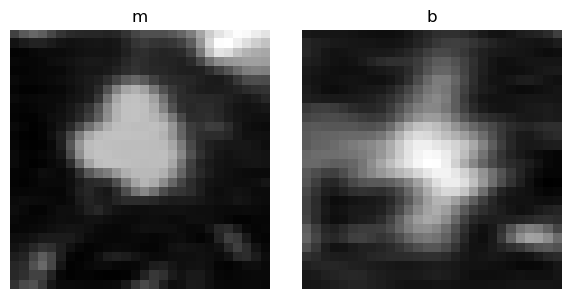

In [ ]:
dls.show_batch(max_n=2, anatomical_plane=2)

_Class imbalance_ is a common challenge in medical datasets, and it is something we're facing in our example dataset:

In [ ]:
print(df.labels.value_counts())

b    986
m    337
Name: labels, dtype: int64


There are multiple ways to deal with class imbalance. A straightforward technique is to use balancing weights in the model's loss function, i.e., penalizing misclassifications for instances belonging to the minority class more heavily than those of the majority class. 

In [ ]:
train_labels = df.loc[~df.is_val]['labels'].tolist()
class_weights = get_class_weights(train_labels)
print(class_weights)

tensor([0.6709, 1.9627])


In [ ]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

We're now ready to construct a deep learning classification model. 

### Create and train a 3D deep learning model

We import a classification network from MONAI and configure it based on our task, including defining the input image size, the number of classes to predict, channels, etc.  

In [ ]:
from monai.networks.nets import Classifier

model = Classifier(in_shape=[1, 28, 28, 28], classes=2, 
                   channels=(8, 16, 32, 64),strides=(2, 2, 2, 2))

Then we create a `Learner`, which is a fastai object that combines the data and our defined model for training.

In [ ]:
learn = Learner(dls, model,loss_func=loss_func, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(4) 

epoch,train_loss,valid_loss,accuracy,time
0,0.568710,0.464355,0.780303,00:02
1,0.532495,0.512985,0.818182,00:02
2,0.480088,0.471735,0.829545,00:02
3,0.438136,0.436847,0.825758,00:02


**Note:** Small random variations are involved in training CNN models. Hence, when running the notebook, you may see different results.

With the model trained, let's look at some predictions on the validation data. The `show_results` method plots instances, their target values, and their corresponding predictions from the model.

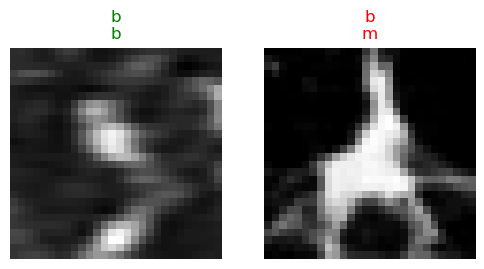

In [ ]:
learn.show_results(max_n=2, anatomical_plane=2) 

### Model evaluation and interpretation

Let's look at how often and for what instances our trained model becomes confused while making predictions on the validation data:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

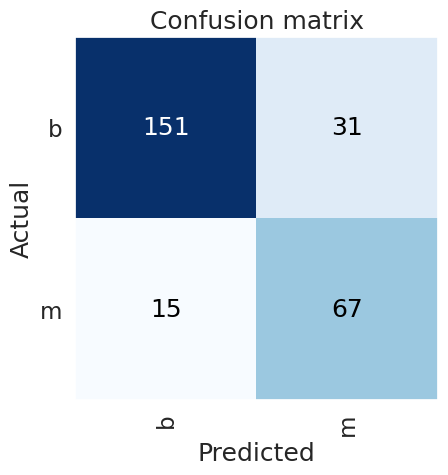

In [ ]:
cm = interp.plot_confusion_matrix()

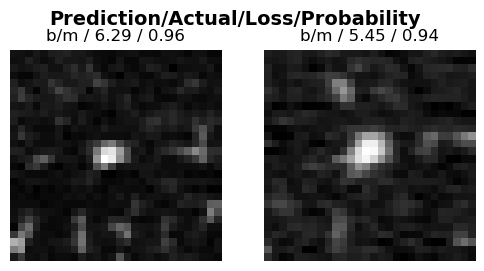

In [ ]:
interp.plot_top_losses(k=2, anatomical_plane=2)

Here are the two instances our model was most confused about (in other words, most confident but wrong):

### Improving results using test-time augmentation

Test-time augmentation (TTA) is a technique where you apply data augmentation transforms when making predictions to produce average output. In addition to often yielding better performance, the variation in the output of the TTA runs can provide some measure of its robustness and sensitivity to augmentations. 

In [ ]:
preds, targs = learn.tta(n=4); 
print(accuracy(preds, targs))

TensorBase(0.8371)


## Semantic segmentation

In the following, we look at another computer vision task while also taking a closer look at the fastMONAI library. Our task will be _semantic segmentation_, and we'll use the IXI Tiny dataset (a small version of the IXI dataset). In semantic segmentation, a class label is assigned to each pixel or voxel in an image, in this case, distinguishing brain tissue from non-brain tissue, i.e., skull-stripping or brain extraction. 

In [ ]:
path = Path('../data')
STUDY_DIR = download_ixi_tiny(path=path)

In [ ]:
df = pd.read_csv(STUDY_DIR/'dataset.csv')

### Inspecting the data

The fastMONAI class `MedDataset` can automatically extract and present valuable information about your dataset:

In [ ]:
med_dataset = MedDataset(path=STUDY_DIR/'image', reorder=True, max_workers=6)

In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,44,55,83,4.13,3.95,2.18,RAS+,../data/IXITiny/image/IXI002-Guys-0828_image.nii.gz,566


In [ ]:
resample, reorder = med_dataset.suggestion()
print(resample, reorder)

[4.13, 3.95, 2.18] True


We can get the largest image size in the dataset with the recommended resampling:

In [ ]:
img_size = med_dataset.get_largest_img_size(resample=resample)
print(img_size)

[44.0, 55.0, 83.0]


In this case, we choose the following size as some network architectues requires the tensor to be divisible by 16. 

In [ ]:
size = [48, 48, 96]

In [ ]:
item_tfms = [PadOrCrop(size), 
             RandomAffine(scales=0.1, degrees=5, p=0.5), RandomFlip(p=0.5), ZNormalization()] 

### Loading the data

As we mentioned earlier, there are several ways to get the data in `DataLoaders`. In this section, let's build the data loaders using `DataBlock`. 
Here we need to define what our input and target should be (`MedImage` and `MedMaskBlock` for segmentation), how to get the images and the labels, how to split the data, item transforms that should be applied during training, reorder voxel orientations, and voxel spacing. Take a look at fastai's documentation for DataBlock for further information: [https://docs.fast.ai/data.block.html#DataBlock](https://docs.fast.ai/data.block.html#DataBlock).

**NB:** It is crucial to select an appropriate splitting strategy. For example, one should, in general, avoid having data from the same patient in both the training and the validation or test set. However, in the IXI data set this is not an issue, as there is only one image per patient.

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(valid_pct=0.2, seed=42),
                      get_x=ColReader('t1_path'), get_y=ColReader('labels'),
                      item_tfms=item_tfms, reorder=reorder, resample=resample) 

Now we pass our processed DataFrame and the batch size (bs) to create a `DataLoaders` object:

In [ ]:
dls = dblock.dataloaders(df, bs=8)

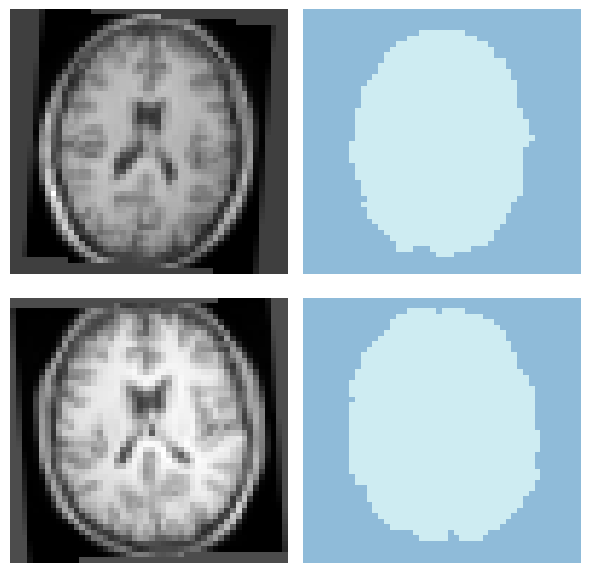

In [ ]:
dls.show_batch(max_n=2, anatomical_plane=2)

In [ ]:
print(len(dls.train_ds.items), len(dls.valid_ds.items))

438 109


### Network architectures and loss functions

You can import various models and loss functions directly from MONAI Core, as shown below: 

In [ ]:
from monai.networks.nets import UNet, AttentionUnet
from monai.losses import DiceLoss, DiceFocalLoss

loss_func = CustomLoss(loss_func=DiceFocalLoss(sigmoid=True))

model = AttentionUnet(spatial_dims=3, in_channels=1, out_channels=1, 
                channels=(16, 32, 64, 128), strides=(2, 2, 2))

In this task, we use the Ranger optimizer [@Ranger], a optimization algorithm that combines RAdam and Lookahead.

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, 
                metrics=[binary_dice_score, binary_hausdorff_distance])

### Finding a good learning rate

We used the default learning rate before, but we might want to find a better value. For this, we can use the learning rate finder of fastai:

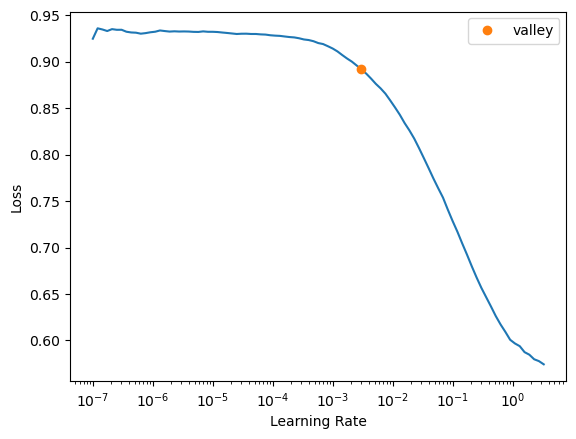

In [ ]:
lr = learn.lr_find()

### Training the model

Now we can train the model. This time we use `fit_flat_cos` method, which is a better learning rate policy for the Ranger optimzer:

In [ ]:
learn.fit_flat_cos(2, lr.valley)

epoch,train_loss,valid_loss,binary_dice_score,binary_hausdorff_distance,time
0,0.448831,0.355411,0.932139,7.755924,00:16
1,0.337796,0.278777,0.959338,5.635414,00:15


In [ ]:
learn.save('model-1')

Path('models/model-1.pth')

### Exporting and sharing models

We can export the model and share both the trained weights and the learner on [HuggingFace](https://huggingface.co/docs/hub/repositories-getting-started) and use tagging for marked version release. Version control for shared models is essential for tracking changes and being able to roll back to previous versions if there are any issues with the latest model in production.  

In [ ]:
learn.export('models/export.pkl')
store_variables(pkl_fn='models/vars.pkl', size=size, 
                reorder=reorder, resample=resample)

# Documentation, usability, and maintainability

We have written the entire fastMONAI library using nbdev, a tool for exploratory programming that allows you to write, test, and document a Python library in Jupyter Notebooks. fastMONAI contains several practical tools to ensure the software's user-friendliness. 

fastMONAI comes with a documentation page [https://fastmonai.no](https://fastmonai.no) and step-by-step tutorials on how to use the software for various medical imaging tasks (e.g., classification, regression, and segmentation). Tests are written directly in notebooks, and continuous integration with GitHub Actions runs the tests on each push, making software development easier with multiple collaborators. 

To ease further extensions of our library through contributions, we have added a short guide on how to contribute to the project. As mentioned, this paper is written as a notebook and automatically converted to a markdown file. The latest version is always available on GitHub. 

# Research projects using fastMONAI

The fastMONAI library has been used for various medical imaging tasks, including predicting brain age using T1-weighted scans in [@kaliyugarasan2020brain], skull-stripping in [@kaliyugarasan20202d], pulmonary nodule classification from CT images in [@kaliyugarasan2021pulmonary], and tumor segmentation in cervical cancer from multi-parametric pelvic MRI in [@hodneland2022fully]. Recently, it was also used for vertebra segmentation in a multi-center study [@kaliyugarasan2023spine]. 

# Acknowledgments

The Trond Mohn Research Foundation supported our work through the project _“Computational medical imaging and machine learning - methods, infrastructure and applications”_ at the Mohn Medical Imaging and Visualization Centre, grant number BFS2018TMT07, and a grant from the Western Norway Regional Health Authority (Helse Vest RHF), project F-12532.

# References